In [109]:
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import re

**We fetch the data**

We select one city to start with

In [110]:


# city = 'copenhagen'

# data = pd.read_csv(('listings_' + city + '.csv.gz'), compression='gzip')
# dataframe = data

# data = data[['accommodates','bathrooms_text','bedrooms', 'beds', 'host_since', 'review_scores_rating','review_scores_location','review_scores_value','review_scores_cleanliness','reviews_per_month','number_of_reviews','calculated_host_listings_count','minimum_nights','availability_90','property_type','room_type','amenities','latitude','longitude','price']]

# # data = data[['accommodates','bedrooms','price']]
# data = data.dropna()

# data.shape


In [111]:
def getKilometersFromCenter(data, city):
    kilometers = np.zeros(data.shape[0])
    if city == 'copenhagen':
        center =  [55.6761, 12.5683]
    elif city == 'stockholm':
        center =  [59.3293, 18.0686]
    elif city == 'london':
        center = [51.5072, 0.1276]
    else:
        center = [52.5373, 13.3603]
    for i in range(data.shape[0]):
        data[i, 0] = (data[i, 0]- center[0])*111
        data[i, 1] = (data[i, 1] - center[1])*111
        kilometers[i] = np.linalg.norm(data[i, 0]-data[i, 1])
    return kilometers, data, center

**We define a function to change string features to an integer**

In [112]:
def string_features_to_num(array):
    dictOfWords = { i : np.unique(array)[i] for i in range(0, len(np.unique(array)) ) }
    dictOfWords = {v: k for k, v in dictOfWords.items()}
    
    values = np.zeros(len(array))
    for i in range(len(array)):
        values[i] = dictOfWords.get(array[i])
        
    return values, dictOfWords

In [113]:
def selectPropertyType(type, X, y):
    xlist = []
    ylist = []
    for i in range(X.shape[0]):
        if(X[i,-5] == type):
            xlist.append(X[i,:])
            ylist.append(y[i])
    return np.array(xlist), np.array(ylist)

In [114]:
def oneHotEncodingPropertyType(type, X):
    isType = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        if(X[i,0] == type):
            isType[i] = 1.0
    return isType

In [115]:
def plotPredVsReal(yreal, ypred, limit):
    plt.scatter(yreal, ypred, label="pred vs true")
    plt.plot(yreal, yreal, label="y=x", c='red')
    plt.xlabel("y-real")
    plt.ylabel("y-pred")
    plt.xlim((0,limit))
    plt.ylim((0,limit))
    plt.legend()
    plt.show

In [116]:
def plotFeatureVsPrice(feature, price, featureName):
    plt.scatter(feature, price)
    plt.ylabel("price")
    plt.xlabel(featureName)
    plt.show()

In [117]:
def host_Since_fix(X):
    yearsSince = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        yearsSince[i] = 2022 - int(X[i].split('-')[0])
    return yearsSince

In [118]:
from sklearn.inspection import permutation_importance
def plot_feature_importance(best_model, X, y):
    permut = permutation_importance(best_model, X_val, y_val, scoring='r2')
    importance = permut.importances_mean

    # for i,v in enumerate(importance):
    #     print('Feature: %0d, Score: %.5f' % (i,v))

    plt.bar(range(len(importance)), importance)
    plt.show()

**Data split into features and target**

We also change the target from a string to a float. 

In [119]:
# import re

# datanp = np.array(data)
# X = datanp[:,:-1]
# y = datanp[:,-1]

# bathroomErr = []
# for i in range(X.shape[0]):
#     try:
#         X[i,1] = float(X[i,1].split()[0])
#     except ValueError:
#         bathroomErr.append(i)
# bathroomErr = np.array(bathroomErr)
# X = np.delete(X, bathroomErr, axis=0)
# y = np.delete(y, bathroomErr)

# for i in range(len(y)):
#     y[i] = float(re.sub(",", "", (y[i][1:])))



# X[:,-5], propertytype_dict = string_features_to_num(X[:, -5])
# X[:,-4], roomtype_dict = string_features_to_num(X[:, -4])

# # print(propertytype_dict)
# print(list(enumerate(np.bincount(np.array(X[:, -5],dtype='int64')))))


# # X, y = selectPropertyType(propertytype_dict.get('Entire rental unit'), X, y)

# latitudeAndLongitude = X[:,[-2,-1]]
# kilometers, longAndLat, center = getKilometersFromCenter(latitudeAndLongitude, city)
# X = X[:,:X.shape[1]-2]



# onehotSource = X[:,[-3,-2,-1]]
# X = X[:,:X.shape[1]-3]

# isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire rental unit'), onehotSource)
# X = np.hstack((X, isType.reshape(-1,1)))
# isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire condo'), onehotSource)
# X = np.hstack((X, isType.reshape(-1,1)))
# isType = oneHotEncodingPropertyType(propertytype_dict.get('Private room in rental unit'), onehotSource)
# X = np.hstack((X, isType.reshape(-1,1)))


# # plotFeatureVsPrice(X[:,8], y[:], "Number of Reviews")

# X.shape

In [120]:
def plotCity(longAndLat, y):
    heatmapColors = np.clip(y, 0, 800)
    indexes = np.argsort(y)
    # c=scaler.fit_transform(y.reshape(-1,1))
    plt.scatter(longAndLat[indexes,1], longAndLat[indexes,0], c=heatmapColors[indexes], cmap=mpl.colormaps['hot'])
    plt.colorbar()
    plt.scatter(0, 0, label='center')
    plt.legend()
    plt.show()


In [121]:
# kmindexes = np.argsort(kilometers)
# kilometerCount = round(max(kilometers))
# averagepricebykilometers = np.zeros(kilometerCount)
# sliceSize = round(kilometers.shape[0]/kilometerCount)

# for i in range(kilometerCount):
#     averagepricebykilometers[i] = np.mean(y[kmindexes][i * sliceSize: (i+1) * sliceSize])


# plt.scatter(kilometers,np.clip(y, 0, 2000))
# plt.plot(range(kilometerCount), averagepricebykilometers, c='red')
# plt.show()

# count=0
# for i in range(y.shape[0]):
#     if y[i] <= 300:
#         count+=1
# count

In [122]:
import ast 

def amenitiesOneHot(X, amenityName):
    amenities = []
    for i in range(X.shape[0]):
        amenities.append(ast.literal_eval(X[i,-1]))

    amenity = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(len(amenities[i])):
            if(amenities[i][j]==amenityName):
                amenity[i] = 1
    return amenity

**One Hot encoded features added**

In [123]:
# # np.sum(amenitiesOneHot(X, 'Private patio or balcony'))/X.shape[0]


# patio = amenitiesOneHot(onehotSource, 'Private patio or balcony')
# tv = amenitiesOneHot(onehotSource, 'TV')
# wifi = amenitiesOneHot(onehotSource, 'Wifi')
# bedlinens = amenitiesOneHot(onehotSource, 'Bed linens')
# breakfast = amenitiesOneHot(onehotSource, 'Breakfast')
# bathtub = amenitiesOneHot(onehotSource, 'Bathtub')
# washer = amenitiesOneHot(onehotSource, 'Washer')
# elevator = amenitiesOneHot(onehotSource, 'Elevator')
# pool = amenitiesOneHot(onehotSource, 'Pool')
# hostsince = host_Since_fix(X[:,4])



# onehot = np.hstack((tv.reshape(-1,1), patio.reshape(-1,1)))
# onehot = np.hstack((onehot, wifi.reshape(-1,1)))
# onehot = np.hstack((onehot, bedlinens.reshape(-1,1)))
# onehot = np.hstack((onehot, breakfast.reshape(-1,1)))
# onehot = np.hstack((onehot, bathtub.reshape(-1,1)))
# onehot = np.hstack((onehot, washer.reshape(-1,1)))
# onehot = np.hstack((onehot, elevator.reshape(-1,1)))
# onehot = np.hstack((onehot, pool.reshape(-1,1)))
# onehot = np.hstack((onehot, kilometers.reshape(-1,1)))
# onehot = np.hstack((onehot, longAndLat))
# onehot = np.hstack((onehot, hostsince.reshape(-1,1)))

# X = X[:,:-1]
# X = np.hstack((X[:,:3], X[:,5:]))
# X = np.hstack((X, onehot))
# X.shape


In [124]:
def cleanBathroomFeature(X, y, featureNum):
    bathroomErr = []
    for i in range(X.shape[0]):
        try:
            X[i,featureNum] = float(X[i,featureNum].split()[0])
        except ValueError:
            bathroomErr.append(i)
    bathroomErr = np.array(bathroomErr)
    X = np.delete(X, bathroomErr, axis=0)
    y = np.delete(y, bathroomErr)
    return X, y

In [125]:
def cleanCurrency(y, city):
    exchange =1
    if city=='copenhagen': exchange = 0.1579
    elif city=='stockholm': exchange = 0.088507
    elif city=='london': exchange = 1.1594
    else: exchange = 1.0151

    for i in range(len(y)):
        y[i] = float(re.sub(",", "", (y[i][1:])))*exchange
    return y

In [126]:
def getCityData(city):
    data = pd.read_csv(('listings_' + city + '.csv.gz'), compression='gzip')
    data = data[['accommodates','bathrooms_text','bedrooms', 'beds', 'host_since', 'review_scores_rating','review_scores_location','review_scores_value','review_scores_cleanliness','reviews_per_month','number_of_reviews','calculated_host_listings_count','minimum_nights','availability_90','property_type','room_type','amenities','latitude','longitude','price']]
    data = data.dropna()

    datanp = np.array(data)
    X = datanp[:,:-1]
    y = datanp[:,-1]

    X, y = cleanBathroomFeature(X, y, 1)
    
    y = cleanCurrency(y, city)

    X[:,-5], propertytype_dict = string_features_to_num(X[:, -5])
    X[:,-4], roomtype_dict = string_features_to_num(X[:, -4])

    # print(propertytype_dict)
    #print(list(enumerate(np.bincount(np.array(X[:, -5],dtype='int64')))))
    # X, y = selectPropertyType(propertytype_dict.get('Entire rental unit'), X, y)

    latitudeAndLongitude = X[:,-2:]
    kilometers, longAndLat, center = getKilometersFromCenter(latitudeAndLongitude, city)
    X = X[:,:X.shape[1]-2]

    onehotSource = X[:,-3:]
    X = X[:,:X.shape[1]-3]

    isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire rental unit'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    isType = oneHotEncodingPropertyType(propertytype_dict.get('Entire condo'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))
    isType = oneHotEncodingPropertyType(propertytype_dict.get('Private room in rental unit'), onehotSource)
    X = np.hstack((X, isType.reshape(-1,1)))

    patio = amenitiesOneHot(onehotSource, 'Private patio or balcony')
    tv = amenitiesOneHot(onehotSource, 'TV')
    wifi = amenitiesOneHot(onehotSource, 'Wifi')
    bedlinens = amenitiesOneHot(onehotSource, 'Bed linens')
    breakfast = amenitiesOneHot(onehotSource, 'Breakfast')
    bathtub = amenitiesOneHot(onehotSource, 'Bathtub')
    washer = amenitiesOneHot(onehotSource, 'Washer')
    elevator = amenitiesOneHot(onehotSource, 'Elevator')
    pool = amenitiesOneHot(onehotSource, 'Pool')
    hostsince = host_Since_fix(X[:,4])

    onehot = np.hstack((tv.reshape(-1,1), patio.reshape(-1,1)))
    onehot = np.hstack((onehot, wifi.reshape(-1,1)))
    onehot = np.hstack((onehot, bedlinens.reshape(-1,1)))
    onehot = np.hstack((onehot, breakfast.reshape(-1,1)))
    onehot = np.hstack((onehot, bathtub.reshape(-1,1)))
    onehot = np.hstack((onehot, washer.reshape(-1,1)))
    onehot = np.hstack((onehot, elevator.reshape(-1,1)))
    onehot = np.hstack((onehot, pool.reshape(-1,1)))
    onehot = np.hstack((onehot, kilometers.reshape(-1,1)))
    onehot = np.hstack((onehot, longAndLat))
    onehot = np.hstack((onehot, hostsince.reshape(-1,1)))

    X = X[:,:-1]
    X = np.hstack((X[:,:3], X[:,5:]))
    X = np.hstack((X, onehot))
    return X, y
    # plotFeatureVsPrice(X[:,8], y[:], "Number of Reviews")
    

In [127]:
# a = amenitiesOneHot(X, 'Elevator')
# print(np.sum(a))

# amenities = []
# for i in range(X.shape[0]):
#     amenities.append(ast.literal_eval(X[i,-1]))
# print(amenities)

In [128]:
cX, cy = getCityData('copenhagen')
sX, sy = getCityData('stockholm')
lX, ly = getCityData('london')
bX, by = getCityData('berlin')

print(np.mean(cy), np.mean(sy), np.mean(ly), np.mean(by))


184.17074352340447 124.04862221423747 184.5503667823852 98.5019178410668


**Data split into train/val/test**

In [129]:
X_train, X_testval, y_train, y_testval = train_test_split(cX, cy, test_size=0.20, random_state=4)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=0.5, random_state=4)

print(X_train.shape, X_test.shape, X_val.shape)

(9400, 27) (1175, 27) (1175, 27)


**Models imported**

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_model = LinearRegression()
svr_model = SVR(C=60, epsilon=0.95)

**Models fit and scored**

We fit the models on the training set and test with the linear regression. 

Training score:  0.19233328978436315
Test score:  0.44460544372259625
Validation score:  0.006215989528638666


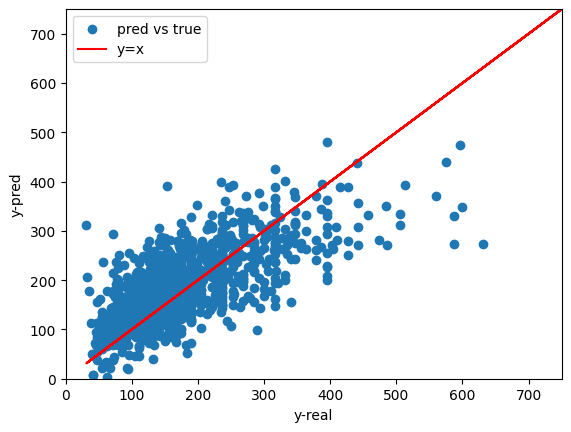

In [131]:
linear_model.fit(X_train, y_train)
linear_train_score = linear_model.score(X_train, y_train)
linear_val_score = linear_model.score(X_val,y_val)
linear_test_score = linear_model.score(X_test,y_test)

print("Training score: ", linear_train_score)
print("Test score: ", linear_test_score)
print("Validation score: ", linear_val_score)

plotPredVsReal(y_test, linear_model.predict(X_test), 750)


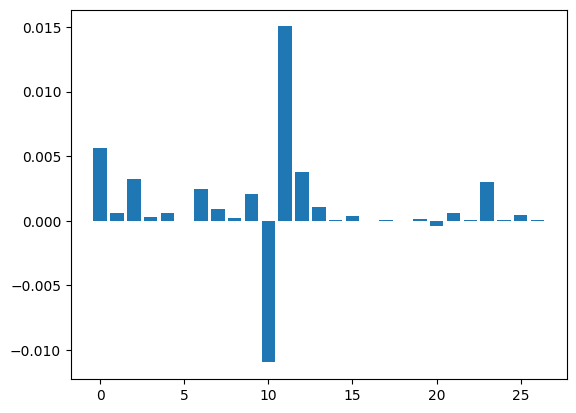

In [132]:
plot_feature_importance(linear_model, X_val, y_val)

In [133]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

Training score: 0.20738430211205405
Test score: 0.502164358818293
Validation score: 0.03188352348026857


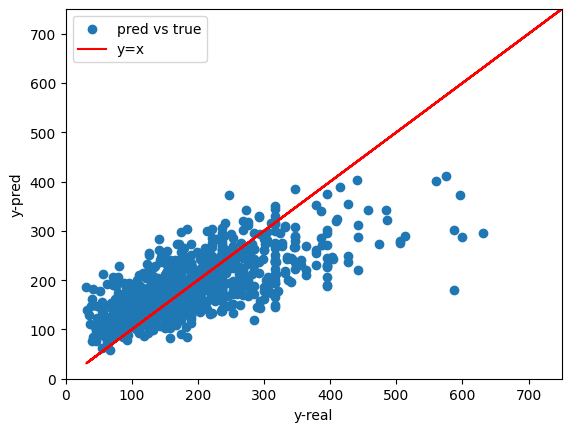

In [134]:
from sklearn.svm import NuSVR
best_score = 0
best_model = NuSVR()
for i in range(20):
    svr_model = NuSVR(C=4*i+1, nu=0.04*i+0.005)
    svr_model.fit(X_train, y_train)
    score = svr_model.score(X_val, y_val)
    if(score >best_score):
        best_score = score
        best_model = svr_model



svr_train_score = best_model.score(X_train, y_train)
svr_test_score = best_model.score(X_test, y_test)
svr_val_score = best_model.score(X_val, y_val)
print("Training score:", svr_train_score)
print("Test score:", svr_test_score)
print("Validation score:", svr_val_score)

plotPredVsReal(y_test, best_model.predict(X_test), 750)


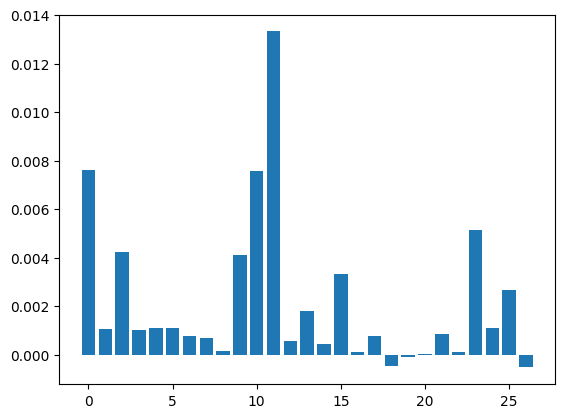

In [135]:
plot_feature_importance(best_model, X_val, y_val)

In [136]:
best_model.score(lX, ly)

-8.993683909386263e-06

Training score:  0.33789187796346865
Test score:  0.2041618343880508
Validation score:  0.02096958438258434


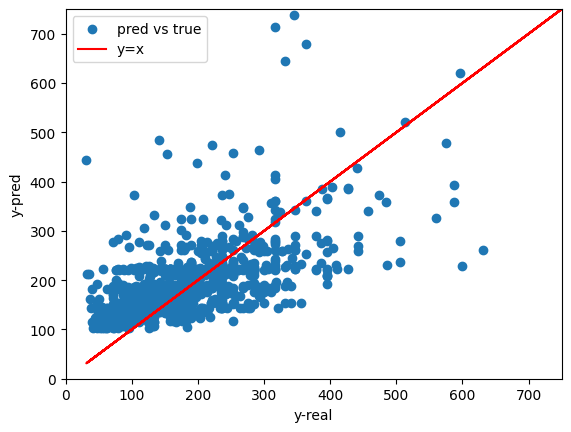

In [137]:
from sklearn.ensemble import RandomForestRegressor
best_score = 0
best_model = RandomForestRegressor()
for i in range(8):
    regr_model = RandomForestRegressor(max_depth=int(i*0.5+4), random_state=0, n_estimators=12*i+20)
    regr_model.fit(X_train, y_train)
    score = regr_model.score(X_val, y_val)
    if(score >best_score):
        best_score = score
        best_model = regr_model



regr_train_score = best_model.score(X_train, y_train)
regr_test_score = best_model.score(X_test, y_test)
regr_val_score = best_model.score(X_val, y_val)

print("Training score: ", regr_train_score)
print("Test score: ", regr_test_score)
print("Validation score: ", regr_val_score)


plotPredVsReal(y_test, best_model.predict(X_test), 750)



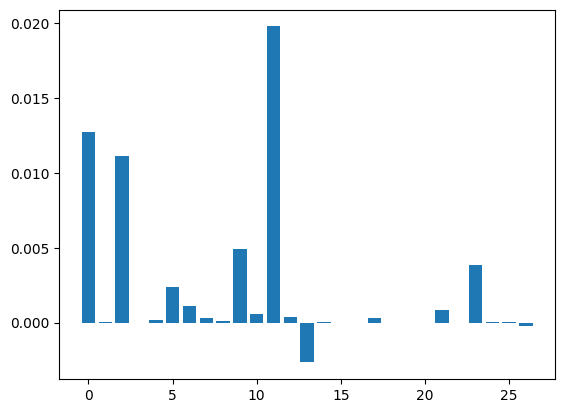

In [138]:
plot_feature_importance(best_model, X_val, y_val)

In [139]:
from sklearn.linear_model import Lasso


lasso_model = Lasso(alpha=6)
lasso_model.fit(X_train, y_train)

lasso_train_score = lasso_model.score(X_train, y_train)
lasso_test_score = lasso_model.score(X_test, y_test)
lasso_val_score = lasso_model.score(X_val, y_val)

print("Training score: ", lasso_train_score)
print("Test score: ", lasso_test_score)
print("Validation score: ", lasso_val_score)


Training score:  0.1727497762587331
Test score:  0.4239977208600364
Validation score:  0.018400410132572764


[0]	validation_0-rmse:408.11597
[1]	validation_0-rmse:396.75536
[2]	validation_0-rmse:389.00064
[3]	validation_0-rmse:383.50072
[4]	validation_0-rmse:380.34349
[5]	validation_0-rmse:377.88399
[6]	validation_0-rmse:376.13748
[7]	validation_0-rmse:374.94701
[8]	validation_0-rmse:374.25571
[9]	validation_0-rmse:373.69726
[10]	validation_0-rmse:373.30354
[11]	validation_0-rmse:372.00235
[12]	validation_0-rmse:371.71631
[13]	validation_0-rmse:371.57469
[14]	validation_0-rmse:371.04776
[15]	validation_0-rmse:370.24404
[16]	validation_0-rmse:370.06098
[17]	validation_0-rmse:370.07101
[18]	validation_0-rmse:369.87847
[19]	validation_0-rmse:369.29999
[20]	validation_0-rmse:369.35660
[21]	validation_0-rmse:369.39002
[22]	validation_0-rmse:369.37002
[23]	validation_0-rmse:369.42073
[24]	validation_0-rmse:369.35532
[25]	validation_0-rmse:369.40811
[26]	validation_0-rmse:369.39891
[27]	validation_0-rmse:369.42089
[28]	validation_0-rmse:369.43788
[29]	validation_0-rmse:369.32515
[30]	validation_0-rm

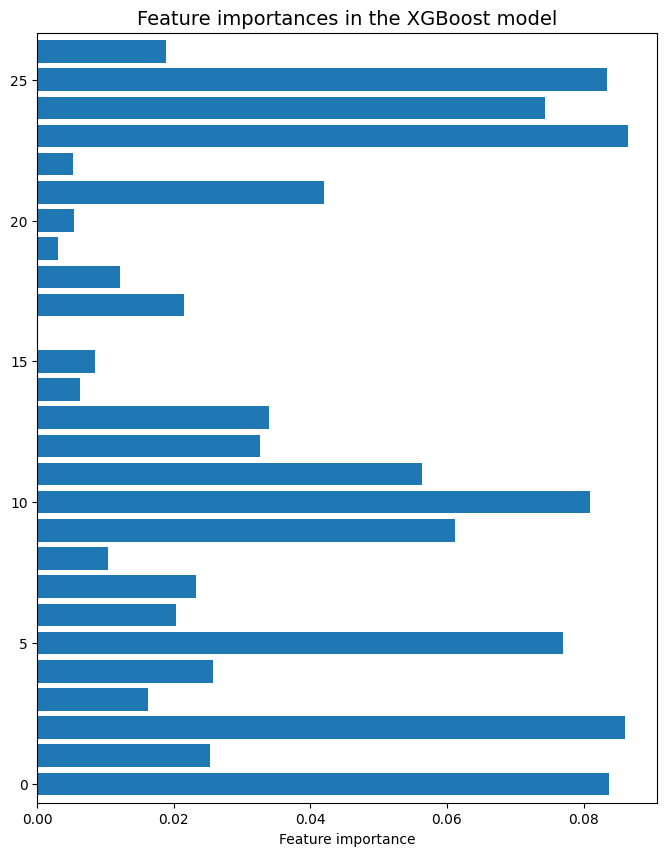

In [140]:
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import xgboost as xgb



X_train = pd.DataFrame(X_train, dtype='float')
X_test = pd.DataFrame(X_test, dtype='float')
X_val = pd.DataFrame(X_val, dtype='float')


y_train = pd.DataFrame(y_train, dtype='float')
y_test = pd.DataFrame(y_test, dtype='float')
y_val = pd.DataFrame(y_val, dtype='float')

# Fitting the model
# learning_rate=0.3, gamma =0.3 ,max_depth=3, n_estimators=17,


eval_set = [(X_val, y_val)]

xgb_reg = xgb.XGBRegressor(learning_rate=0.2, max_depth=3, subsample=0.9, colsample_bytree = 0.7, n_estimators=100, eval_metric="rmse")
# , verbose=True
xgb_reg.fit(X_train, y_train, eval_set=eval_set)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_val)
test_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_val, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,10))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()



In [145]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import r2_score

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_val = pd.DataFrame(y_val)

def scale_datasets(x_train, x_test, x_val):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test),
        columns = x_test.columns
    )
    x_val_scaled = pd.DataFrame(
        standard_scaler.transform(x_val),
        columns = x_val.columns
    )
    return x_train_scaled, x_test_scaled, x_val_scaled
x_train_scaled, x_test_scaled, x_val_scaled = scale_datasets(X_train, X_test, X_val)

In [149]:
hidden_units1 = 200
hidden_units2 = 520
hidden_units3 = 256
learning_rate = 5e-5
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [150]:
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    x_train_scaled.values, 
    np.asarray(y_train.values).astype('float32'), 
    epochs=10, 
    batch_size=16,
    validation_split=0.2
)

Epoch 1/10
  7/470 [..............................] - ETA: 3s - loss: 25.9227 - mean_squared_logarithmic_error: 25.9227  

2022-11-15 06:23:35.588731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


465/470 [============================>.] - ETA: 0s - loss: 11.6403 - mean_squared_logarithmic_error: 11.6403

2022-11-15 06:23:39.503493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


470/470 [==============================] - 5s 9ms/step - loss: 11.5537 - mean_squared_logarithmic_error: 11.5537 - val_loss: 3.7589 - val_mean_squared_logarithmic_error: 3.7620
Epoch 2/10
470/470 [==============================] - 3s 6ms/step - loss: 1.8951 - mean_squared_logarithmic_error: 1.8951 - val_loss: 0.8887 - val_mean_squared_logarithmic_error: 0.8899
Epoch 3/10
470/470 [==============================] - 3s 7ms/step - loss: 0.5355 - mean_squared_logarithmic_error: 0.5355 - val_loss: 0.3367 - val_mean_squared_logarithmic_error: 0.3370
Epoch 4/10
470/470 [==============================] - 3s 6ms/step - loss: 0.2675 - mean_squared_logarithmic_error: 0.2675 - val_loss: 0.2188 - val_mean_squared_logarithmic_error: 0.2187
Epoch 5/10
470/470 [==============================] - 2s 5ms/step - loss: 0.2048 - mean_squared_logarithmic_error: 0.2048 - val_loss: 0.1844 - val_mean_squared_logarithmic_error: 0.1843
Epoch 6/10
470/470 [==============================] - 3s 5ms/step - loss: 0.179

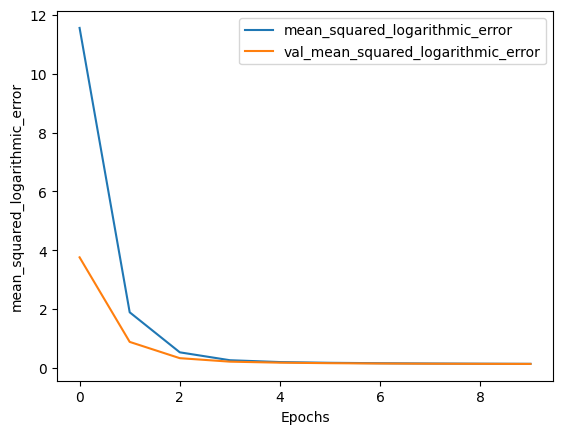

 81/294 [=======>......................] - ETA: 0s

2022-11-15 06:24:04.446907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


294/294 [==============================] - 1s 2ms/step
Training score: 0.16625736422986837
37/37 [==============================] - 0s 2ms/step
Test score: 0.41523129807130643
37/37 [==============================] - 0s 2ms/step
Validation score: 0.027483545327419923


In [151]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

# X_test['prediction'] = model.predict(x_test_scaled)

print("Training score:", r2_score(y_train, model.predict(x_train_scaled)))
print("Test score:", r2_score(y_test, model.predict(x_test_scaled)))
print("Validation score:", r2_score(y_val, model.predict(x_val_scaled)))

# scale_datasets
# print("Stockholm score:", r2_score(y_val, model.predict(x_val_scaled)))
# print("London score:", r2_score(y_val, model.predict(x_val_scaled)))
# print("Berlin score:", r2_score(y_val, model.predict(x_val_scaled)))
